In [1]:
!pip3 install pytorch_transformers

### Загружаем датасет из задания 1

In [2]:
from google.colab import drive

drive.mount('/content/drive')

#!cp drive/'My Drive'/'Colab Notebooks'/BERT/'Bert News'/news_3k.csv ./news_3k.csv
!cp drive/'My Drive'/'Colab Notebooks'/BERT/'Bert News'/news_15k.csv ./news_15k.csv

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd

#data = pd.read_csv('news_3k.csv', sep=';')
data = pd.read_csv('news_15k.csv', sep=';')
data['tags'] = data['tags'].apply(lambda l: eval(l) if '[' in l else l)
data.head()

,title,content,url,tags,source
0,Прятавший мальчика в подвале мужчина несколько...,Более 50 дней удерживавший семилетнего Савели...,http://www.vesti.ru/article/2488087,"[происшествия, новости, ребенок, похищение, Вл...",VestiNewsParser
1,В подмосковном лесу нашли связанный труп с пак...,В минувший понедельник неподалеку от деревни ...,http://www.vesti.ru/article/2488068,"[происшествия, убийство, новости, Клин, Москов...",VestiNewsParser
2,ФИФА вручит приз The Best лучшим футболистам с...,В отличие от французского еженедельника Franc...,http://www.vesti.ru/article/2488047,"[спорт, новости, футбол, Золотой мяч, ФИФА/FIFA]",VestiNewsParser
3,Главред RT аплодирует новому закону об информа...,"Изменений в федеральный закон ""Об информации ...",http://www.vesti.ru/article/2488029,"[политика, новости, безопасность, закон, Росси...",VestiNewsParser
4,Ученые нашли в водах Крыма неизвестные науке в...,В Крыму учёные описали неизвестные науке виды...,http://www.vesti.ru/article/2488031,"[общество, ученые, открытие/изобретение, новос...",VestiNewsParser


### Пытаемся найти в тегах новостей общие метки и составить из них выборку

In [4]:
from collections import Counter

vesti_count = Counter()
for tags in data[data.source == 'VestiNewsParser'].tags:
    vesti_count += Counter([t.lower() for t in tags])

set_vesti = set(vesti_count)

In [5]:
from collections import Counter

lenta_count = Counter()
for tags in data[data.source == 'LentaNewsParser'].tags:
    lenta_count += Counter([tags.lower()])

set_lenta = set(lenta_count)

In [6]:
classes = lenta_count + vesti_count

for key in classes.copy():
  if classes[key] < 100:
    del classes[key]

classes = set(classes)

In [7]:
#classes = set(set_vesti) & set(set_lenta)
#classes

In [8]:
def check_class(row):
    if row['source'] == 'VestiNewsParser':
        for tag in row['tags']:
          if tag.lower() in classes:
            return tag
    elif row['source'] == 'LentaNewsParser':
        tag = row['tags'].lower()
        if tag in classes:
          return tag
    else:
      for cls in classes:
        if cls in row['content']:
          return cls

data['main_class'] = data.apply(check_class, axis=1)
data['main_class'].value_counts()

общество           2941
орган              1545
политика           1330
происшествия        851
спорт               699
чита                692
культура            483
вор                 467
музыка              464
экономика           391
коронавирус         387
исследования        387
самолет             386
закон               386
закавказье          267
наука               192
следствие и суд     151
тв и радио          139
кино                122
госэкономика        119
бокс и мма          112
квартира            112
футбол              111
белоруссия          100
люди                100
россия               79
новости              66
регионы              45
криминал             38
космос               31
москва               23
концерт              21
Name: main_class, dtype: int64

In [9]:
#data = data[data['main_class'] != 'общество']

In [10]:
data = data[~data['main_class'].isna()]
print(data.shape)
data.head()

(13237, 6)


,title,content,url,tags,source,main_class
0,Прятавший мальчика в подвале мужчина несколько...,Более 50 дней удерживавший семилетнего Савели...,http://www.vesti.ru/article/2488087,"[происшествия, новости, ребенок, похищение, Вл...",VestiNewsParser,происшествия
1,В подмосковном лесу нашли связанный труп с пак...,В минувший понедельник неподалеку от деревни ...,http://www.vesti.ru/article/2488068,"[происшествия, убийство, новости, Клин, Москов...",VestiNewsParser,происшествия
2,ФИФА вручит приз The Best лучшим футболистам с...,В отличие от французского еженедельника Franc...,http://www.vesti.ru/article/2488047,"[спорт, новости, футбол, Золотой мяч, ФИФА/FIFA]",VestiNewsParser,спорт
3,Главред RT аплодирует новому закону об информа...,"Изменений в федеральный закон ""Об информации ...",http://www.vesti.ru/article/2488029,"[политика, новости, безопасность, закон, Росси...",VestiNewsParser,политика
4,Ученые нашли в водах Крыма неизвестные науке в...,В Крыму учёные описали неизвестные науке виды...,http://www.vesti.ru/article/2488031,"[общество, ученые, открытие/изобретение, новос...",VestiNewsParser,общество


### Задаем классам цифровые обозначения и дообучаем BERT

In [13]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

Tesla T4


In [14]:
class_labels = {}
for index, cls in enumerate(data['main_class'].unique()):
    class_labels[cls] = index

class_labels   

{'белоруссия': 21,
 'бокс и мма': 9,
 'вор': 30,
 'госэкономика': 15,
 'закавказье': 10,
 'закон': 28,
 'исследования': 25,
 'квартира': 12,
 'кино': 14,
 'концерт': 8,
 'коронавирус': 26,
 'космос': 16,
 'криминал': 22,
 'культура': 5,
 'люди': 20,
 'москва': 11,
 'музыка': 17,
 'наука': 4,
 'новости': 7,
 'общество': 3,
 'орган': 27,
 'политика': 2,
 'происшествия': 0,
 'регионы': 24,
 'россия': 18,
 'самолет': 29,
 'следствие и суд': 13,
 'спорт': 1,
 'тв и радио': 19,
 'футбол': 23,
 'чита': 31,
 'экономика': 6}

In [15]:
import pandas as pd
from string import punctuation

BATCH_SIZE = 64
MAX_LEN = 1024

dataset = data.copy()
dataset['labels_classes'] = dataset['main_class'].apply(lambda x: class_labels[x])

dataset['title'] = dataset['title'].apply(lambda s: "[CLS] " + s.strip(punctuation) + " [SEP]")
dataset = dataset[dataset['title'].str.len() <= MAX_LEN]
print(dataset.shape)
dataset.head()

(13237, 7)


,title,content,url,tags,source,main_class,labels_classes
0,[CLS] Прятавший мальчика в подвале мужчина нес...,Более 50 дней удерживавший семилетнего Савели...,http://www.vesti.ru/article/2488087,"[происшествия, новости, ребенок, похищение, Вл...",VestiNewsParser,происшествия,0
1,[CLS] В подмосковном лесу нашли связанный труп...,В минувший понедельник неподалеку от деревни ...,http://www.vesti.ru/article/2488068,"[происшествия, убийство, новости, Клин, Москов...",VestiNewsParser,происшествия,0
2,[CLS] ФИФА вручит приз The Best лучшим футболи...,В отличие от французского еженедельника Franc...,http://www.vesti.ru/article/2488047,"[спорт, новости, футбол, Золотой мяч, ФИФА/FIFA]",VestiNewsParser,спорт,1
3,[CLS] Главред RT аплодирует новому закону об и...,"Изменений в федеральный закон ""Об информации ...",http://www.vesti.ru/article/2488029,"[политика, новости, безопасность, закон, Росси...",VestiNewsParser,политика,2
4,[CLS] Ученые нашли в водах Крыма неизвестные н...,В Крыму учёные описали неизвестные науке виды...,http://www.vesti.ru/article/2488031,"[общество, ученые, открытие/изобретение, новос...",VestiNewsParser,общество,3


## Удалим слишком большие и слишком маленькие значения

In [16]:
dataset_v_c = dataset['labels_classes'].value_counts()
dataset_v_c

3     2941
27    1545
2     1330
0      851
1      699
31     692
5      483
30     467
17     464
6      391
26     387
25     387
29     386
28     386
10     267
4      192
13     151
19     139
14     122
15     119
9      112
12     112
23     111
20     100
21     100
18      79
7       66
24      45
22      38
16      31
11      23
8       21
Name: labels_classes, dtype: int64

In [17]:
classes_to_save = list()
for key, value in dataset_v_c.to_dict().items():
    if 200 < value < 1000:
      classes_to_save.append(key)

dataset = dataset[dataset['labels_classes'].isin(classes_to_save)]
dataset.shape

(5860, 7)

### Начинаем обучение

In [23]:
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences


labels = list(dataset['labels_classes'])
sentences = list(dataset['title'])

train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.3)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, max_len=MAX_LEN)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print(tokenized_texts[0][0:50])

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

print()
print(input_ids)

['[CLS]', 'р', '##б', '##к', ':', '«', 'а', '##э', '##р', '##о', '##ф', '##л', '##о', '##т', '»', 'з', '##а', 'д', '##в', '##а', 'г', '##о', '##д', '##а', 'п', '##е', '##р', '##е', '##д', '##а', '##с', '##т', 'в', '##с', '##е', 'с', '##у', '##п', '##е', '##р', '##д', '##ж', '##е', '##т', '##ы', 'с', '##в', '##о', '##е', '##и']

[[  101  1195 29740 ...     0     0     0]
 [  101  1182  1194 ...     0     0     0]
 [  101  1184 25529 ...     0     0     0]
 ...
 [  101  1182  1195 ...     0     0     0]
 [  101  1181 29113 ...     0     0     0]
 [  101  1181 29748 ...     0     0     0]]


In [24]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.2
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.2
)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

train_labels

tensor([ 6, 28, 31,  ..., 26,  0, 25])

In [25]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_transformers import AdamW, BertForSequenceClassification

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=BATCH_SIZE
)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=BATCH_SIZE
)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(class_labels))
model.cuda()

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

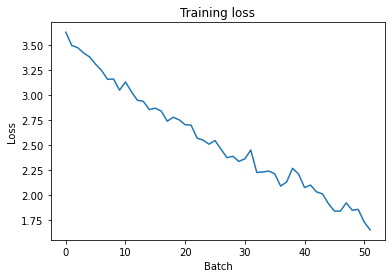

Loss на обучающей выборке: 2.55104


In [26]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Сохраняем loss для графика
train_loss_set = []
train_loss = 0

# Обучение
model.train()

for step, batch in enumerate(train_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Backward pass
    loss[0].backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()

print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

In [27]:
import numpy as np
from sklearn.metrics import accuracy_score

# Валидация
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = label_ids
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на валидационной выборке: 89.04%
